### Presentation #3: Bright Daniels, Kurt Vetter, Hunter Merriman

Implemented Autoencoder to try to extract small number of countries in Presentation #2 dataset at war, trying to prove hypothesis of the correlation between mortality rate and country at war. Autoencoders are useful for exploiting low-dimensional features in high-dimensional data.

Description of Autoencoder Code:    

Loads the CSV dataset.

Renames columns as specified:

“Entity” → “Country”

“GDP per capita” → “GDP”

“State involved in war - Conflict type: all” → “At War”

Removes the columns “Geo_Code”, “Mortality Level”, and “GDP per capital rank”.

Saves the updated DataFrame to a new CSV file.

Preprocesses the data (encoding categorical variables and scaling numerical values) for training a simple neural network autoencoder that “extracts features” (i.e. learns a low‐dimensional representation).

Uses the encoder part of the autoencoder to generate two latent features.

Computes and prints a correlation matrix between key features (with encoded versions for categorical ones) and the new latent features in order to “quantify the feature relationships” among Country, Mortality_Rate, GDP, and At War.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

# ------------------------------
# 1. Load the dataset
# ------------------------------
input_filename = 'mm_updated_dataset.csv'
df = pd.read_csv(input_filename)

# ------------------------------
# 2. Rename columns as specified
# ------------------------------
df.rename(columns={
    "Entity": "Country",
    "GDP per capita": "GDP",
    "State involved in war - Conflict type: all": "At War"
}, inplace=True)

# ------------------------------
# 3. Remove specified columns
# ------------------------------
df.drop(columns=["Geo_Code", "Geo_Type", "Mortality Level", "GDP per capital rank"], inplace=True)


# ------------------------------
# 4. Save the updated file
# ------------------------------
output_filename = 'mm_updated_NN_dataset.csv'
df.to_csv(output_filename, index=False)
print(f"Updated dataset saved to {output_filename}")



Updated dataset saved to mm_updated_NN_dataset.csv


Use re-merged files provided by Bright "unique_mm.csv"

In [ ]:
# Load the  re-merged dataset
input_filename = 'mm_updated_NN_dataset.csv'
df = pd.read_csv(input_filename)


# ------------------------------
# 5. Preprocess data for neural network
# ------------------------------
# Here we want to study relationships between these four features:
#   - Country (categorical)
#   - Mortality_Rate (assumed numeric; note: Mortality Level was removed, so we assume Mortality_Rate exists)
#   - GDP (numeric)
#   - At War (likely categorical; here we assume values such as 'Yes'/'No')

# Encode the 'Country' column into numeric labels.
country_le = LabelEncoder()
df['Country_enc'] = country_le.fit_transform(df['Country'])

# For the 'At War' feature, convert categorical text into a binary indicator.
# Adjust the mapping as needed (this example assumes any value that looks affirmative is 1, else 0).
if df['At War'].dtype == object:
    df['At War_enc'] = df['At War'].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'at war', 'true'] else 0)
else:
    df['At War_enc'] = df['At War']

# Check that Mortality_Rate exists; if not, you may need to adjust based on your actual column names.
if 'Mortality_Rate' not in df.columns:
    raise KeyError("Expected column 'Mortality_Rate' not found in the dataset.")

# Select the features to analyze using numeric columns.
feature_cols = ['Country_enc', 'Mortality_Rate', 'At War_enc']
data = df[feature_cols].values

# Scale features to [0, 1] to help training the neural network.
#scaler = MinMaxScaler()
#data_scaled = scaler.fit_transform(data)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)        # based on Brights re-merged dataset

Implement Autoencoder Neural Network

In [5]:
# ------------------------------
# 6. Build and train an autoencoder for feature extraction
# ------------------------------
# We choose a low-dimensional (here 2 neurons) latent space so that we can later study how these new features relate to the original ones.
input_dim = data_scaled.shape[1]
encoding_dim = 2  # the size of our bottleneck layer

# Define the autoencoder architecture.
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Full autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)

# Encoder model to extract latent features
encoder = Model(inputs=input_layer, outputs=encoded)

# Compile the model using mean squared error loss.
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder.
# (For demonstration, the number of epochs is modest. For better performance, you might increase epochs and adjust batch size.)
autoencoder.fit(data_scaled, data_scaled,
                epochs=50,
                batch_size=16,
                shuffle=True,
                verbose=1)

# ------------------------------
# 7. Extract the latent features using the encoder
# ------------------------------
encoded_features = encoder.predict(data_scaled)
encoded_df = pd.DataFrame(encoded_features, columns=['encoded_feature_1', 'encoded_feature_2'])

# Concatenate the new features with the original DataFrame.
df = pd.concat([df, encoded_df], axis=1)

# ------------------------------
# 8. Quantify the feature relationships
# ------------------------------
# Here, we compute the correlation matrix among the encoded features and the key original features,
# namely Country_enc, Mortality_Rate, GDP, and At War_enc.
#cols_to_correlate = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'encoded_feature_1', 'encoded_feature_2']
cols_to_correlate = ['Country_enc', 'Mortality_Rate','At War']   # based on Brights re-merged dataset

corr_matrix = df[cols_to_correlate].corr()
print("\nCorrelation Matrix:")
print(corr_matrix)

# Optionally, if you want to inspect the correlations related only to the original features:
original_corr = df[['Country_enc', 'Mortality_Rate', 'At War_enc']].corr()
print("\nOriginal Feature Correlation Matrix:")
print(original_corr)


Epoch 1/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 0.1303
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 658us/step - loss: 0.0758
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - loss: 0.0532
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 0.0470
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - loss: 0.0428
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0372
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.0319
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 0.0285
Epoch 9/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 0.0238
Epoch 10/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 0.0211
Epoch 11/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0174
Epoch 12/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step - loss: 0.0156
Epoch 13/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0136
Epoch 14/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0114
Epoch 15/50
241/241 ━━━━━━━━━

Plotting the Correlation Matrix:
The code creates a heatmap of the correlation matrix using plt.imshow(), setting up the color map as 'coolwarm' and labeling both x- and y-axes with feature names. The color bar visually represents the strength of the correlations.

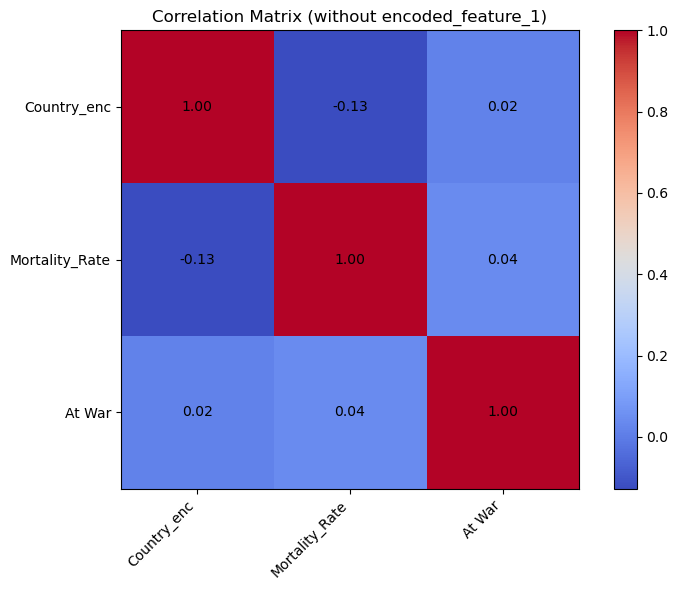

In [6]:
import matplotlib.pyplot as plt
# Remove 'encoded_feature_1' from the correlation matrix
#corr_plot = corr_matrix.drop(index='encoded_feature_1', columns=['encoded_feature_1'])

corr_plot = corr_matrix.drop(index='encoded_feature_1', columns=['encoded_feature_1'], errors='ignore')   #

# Plot the reduced correlation matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_plot, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

# Set ticks and labels
ticks = np.arange(len(corr_plot.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_plot.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_plot.index)

# Annotate each cell with the correlation value
for i in range(corr_plot.shape[0]):
    for j in range(corr_plot.shape[1]):
        ax.text(j, i, f"{corr_plot.iloc[i, j]:.2f}", ha="center", va="center", color="black")

ax.set_title("Correlation Matrix (without encoded_feature_1)")
plt.tight_layout()
plt.show()

Encoded features, often referred to as latent features, are lower-dimensional representations that an autoencoder learns in order to efficiently capture the essence of the input data. In the context of the provided autoencoder, the network compresses information from four input features—Country (encoded numerically), Mortality_Rate, GDP, and At War (binary encoded)—into two encoded features. Here are several key aspects of these encoded features:

1. Dimensionality Reduction
Compression of Information:
The autoencoder is designed with a bottleneck layer of two neurons. This forces the network to learn a compressed version of the original data, retaining only the most significant information. It reduces complexity by mapping a higher-dimensional input space (four features) into a lower-dimensional space (two latent features).

Data Denoising:
Since the autoencoder’s training objective is to reconstruct the original input from the compressed representation, it automatically filters out noise or redundant information. The latent features thus summarize the dominant patterns in the data.

2. Nonlinear Feature Extraction
Capturing Complex Patterns:
Unlike simple linear methods (such as principal component analysis), the neural network can learn nonlinear transformations. This means that the latent features might capture complex, nonlinear relationships between GDP, Mortality_Rate, the encoded Country, and At War indicators.

Abstract Representation:
The encoded features are not direct copies of any one input variable. Instead, they are abstract combinations of the original features, which can represent interactions or emergent properties that are not immediately obvious from the raw data.

3. Interpretability and Analysis
Correlation With Original Variables:
By examining the correlation matrix (as plotted in the code), you can assess how each latent feature relates to the original variables. For instance, one encoded feature might show strong correlation with GDP and Mortality_Rate, suggesting that it captures an economic or socio-health aspect, while the other might be more strongly correlated with the categorical features (Country and At War), hinting at how geopolitical factors manifest in the data.

Unsupervised Nature:
The latent features are learned without any explicit labels or targets. Their meaning is derived purely from the structure of the data. Therefore, while correlations can offer hints about what each latent dimension represents, their interpretation requires careful analysis and sometimes domain expertise to understand the underlying trends they capture.

Potential Use Cases:
These features can be used as inputs to other machine learning models, for clustering, or for visualization purposes. Because they reduce the dimensionality while preserving critical information, they can help simplify analyses and reveal hidden patterns.

4. Limitations
Ambiguity:
Since the encoded features result from unsupervised learning, there is no inherent guarantee that they directly correspond to a single interpretable concept. They are typically “entangled,” meaning that each feature might capture a mix of the original variable characteristics.

Dependence on Network Architecture:
The nature of the extracted features can be sensitive to the network structure (e.g., number of layers, activation functions) and hyperparameters (e.g., learning rate, batch size). Adjusting these parameters may lead to different representations.

Summary
In summary, the two encoded features derived by the autoencoder are sophisticated, compressed representations of the original dataset. They integrate multiple input signals into distilled forms that aim to preserve the essential variance in the data while filtering out noise and redundancy. Analyzing their correlation with the original features can offer insights into what kinds of information they capture, whether economic, demographic, or geopolitical trends, but interpreting them concretely often requires additional context or domain-specific knowledge.

In [7]:
print(encoded_df['encoded_feature_1'].describe())
print(encoded_df['encoded_feature_2'].describe())

count    3844.000000
mean        1.971505
std         0.475384
min         0.000000
25%         1.875195
50%         2.173551
75%         2.228345
max         2.301656
Name: encoded_feature_1, dtype: float64
count    3844.000000
mean        1.670860
std         0.756265
min         0.000000
25%         1.055827
50%         1.683015
75%         2.310948
max         2.969489
Name: encoded_feature_2, dtype: float64


Let's try optimizing the Autoencoder

In [8]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_autoencoder(encoding_dim=2, optimizer='adam'):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)
    decoded = Dense(input_dim, activation='sigmoid')(encoded)
    
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')
    return autoencoder
model = KerasRegressor(model=build_autoencoder, verbose=0)
param_grid = {
    'model__encoding_dim': [2, 4, 8],
    'model__optimizer': ['adam', 'sgd'],
    'epochs': [50, 100],
    'batch_size': [16, 32]
}

# Perform grid search to find the best hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(data_scaled, data_scaled)

print(f"Best parameters: {grid_result.best_params_}")


Best parameters: {'batch_size': 16, 'epochs': 100, 'model__encoding_dim': 8, 'model__optimizer': 'adam'}


In [11]:
from tensorflow.keras.models import Model

# Get the best estimator's model from grid search
best_model = grid_result.best_estimator_.model_

# Create an encoder model that outputs the bottleneck layer
encoder_best = Model(inputs=best_model.input, outputs=best_model.layers[1].output)

# Predict the latent features using the best autoencoder
encoded_features_best = encoder_best.predict(data_scaled)
n_features = encoded_features_best.shape[1]
column_names = [f'best_encoded_feature_{i+1}' for i in range(n_features)]
encoded_df_best = pd.DataFrame(encoded_features_best, columns=column_names)

# Add the new features to a copy of the original DataFrame for correlation analysis
df_best = df.copy()
if 'Country_enc' not in df_best.columns:
    df_best['Country_enc'] = country_le.transform(df_best['Country'])
if 'At War_enc' not in df_best.columns:
    df_best['At War_enc'] = df_best['At War'].apply(lambda x: 1 if str(x).strip().lower() in ['yes', 'at war', 'true'] else 0)
df_best[column_names] = encoded_df_best

# Create correlation matrix using original features and the new latent features
#cols = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'best_encoded_feature_1', 'best_encoded_feature_2'] # based on Brights re-merged dataset
cols = ['Country_enc', 'Mortality_Rate', 'At War_enc', 'best_encoded_feature_1', 'best_encoded_feature_2']
corr_matrix_best = df_best[cols].corr()



121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step


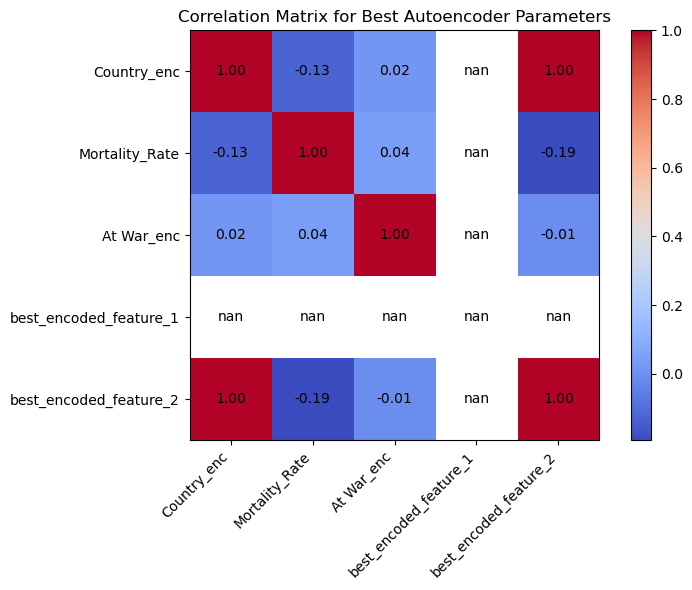

In [12]:
# Plot the correlation matrix heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix_best, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(len(corr_matrix_best.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix_best.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix_best.index)

# Annotate each cell with the correlation value
for i in range(corr_matrix_best.shape[0]):
    for j in range(corr_matrix_best.shape[1]):
        ax.text(j, i, f"{corr_matrix_best.iloc[i, j]:.2f}", 
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix for Best Autoencoder Parameters")
plt.tight_layout()
plt.show()

Try additional Autoencoder optimzation of number of hidden layers and activation function.

In [13]:

from tensorflow.keras.layers import Input, Dense, LeakyReLU
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import StandardScaler

# Assuming data_scaled is your input data
input_dim = data_scaled.shape[1]

# Define the model-building function
def build_autoencoder(encoding_dim=2, hidden_layer_sizes=[64], activation='relu', optimizer='adam'):
    input_layer = Input(shape=(input_dim,))
    x = input_layer

    # Add hidden layers
    for size in hidden_layer_sizes:
        if activation == 'leaky_relu':
            x = Dense(size)(x)
            x = LeakyReLU(alpha=0.1)(x)
        else:
            x = Dense(size, activation=activation)(x)

    # Bottleneck (encoding) layer
    if activation == 'leaky_relu':
        encoded = Dense(encoding_dim)(x)
        encoded = LeakyReLU(alpha=0.1)(encoded)
    else:
        encoded = Dense(encoding_dim, activation=activation)(x)

    # Decoder layers (mirrored)
    x = encoded
    for size in reversed(hidden_layer_sizes):
        if activation == 'leaky_relu':
            x = Dense(size)(x)
            x = LeakyReLU(alpha=0.1)(x)
        else:
            x = Dense(size, activation=activation)(x)

    decoded = Dense(input_dim, activation='sigmoid')(x)

    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer=optimizer, loss='mse')

    return autoencoder

# Wrap the model for scikit-learn compatibility
model = KerasRegressor(build_fn=build_autoencoder, verbose=0)

# Define the parameter grid
param_grid = {
    'model__encoding_dim': [2, 4],
    'model__hidden_layer_sizes': [[32], [64], [128, 64]],
    'model__activation': ['relu', 'tanh', 'leaky_relu'],
    'model__optimizer': ['adam', 'sgd'],
    'epochs': [50],
    'batch_size': [16, 32]
}

# Perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(data_scaled, data_scaled)

# Output best parameters
print("Best parameters found:", grid_result.best_params_)


/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/vetterk/Anaconda/anaconda3/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Err

Best parameters found: {'batch_size': 16, 'epochs': 50, 'model__activation': 'tanh', 'model__encoding_dim': 4, 'model__hidden_layer_sizes': [64], 'model__optimizer': 'adam'}


121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


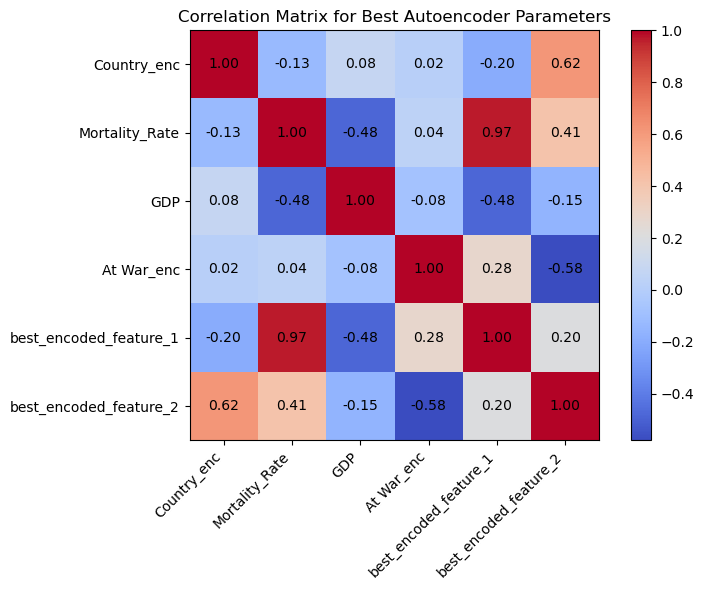

In [14]:
from tensorflow.keras.models import Model

# Get the best estimator's model from grid search
best_model = grid_result.best_estimator_.model_

# Create an encoder model that outputs the bottleneck layer
encoder_best = Model(inputs=best_model.input, outputs=best_model.layers[1].output)

# Predict the latent features using the best autoencoder
encoded_features_best = encoder_best.predict(data_scaled)
n_features = encoded_features_best.shape[1]
column_names = [f'best_encoded_feature_{i+1}' for i in range(n_features)]
encoded_df_best = pd.DataFrame(encoded_features_best, columns=column_names)

# Add the new features to a copy of the original DataFrame for correlation analysis
df_best = df.copy()
df_best[column_names] = encoded_df_best

# Create correlation matrix using original features and the new latent features
cols = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'best_encoded_feature_1', 'best_encoded_feature_2']
corr_matrix_best = df_best[cols].corr()

# Plot the correlation matrix heatmap
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr_matrix_best, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)
ticks = np.arange(len(corr_matrix_best.columns))
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(corr_matrix_best.columns, rotation=45, ha='right')
ax.set_yticklabels(corr_matrix_best.index)

# Annotate each cell with the correlation value
for i in range(corr_matrix_best.shape[0]):
    for j in range(corr_matrix_best.shape[1]):
        ax.text(j, i, f"{corr_matrix_best.iloc[i, j]:.2f}", 
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix for Best Autoencoder Parameters")
plt.tight_layout()
plt.show()

Summary statistics for best_encoded_feature_1:
count    3844.000000
mean       -0.136660
std         0.043741
min        -0.172938
25%        -0.166078
50%        -0.158849
75%        -0.114627
max         0.334968
Name: best_encoded_feature_1, dtype: float64


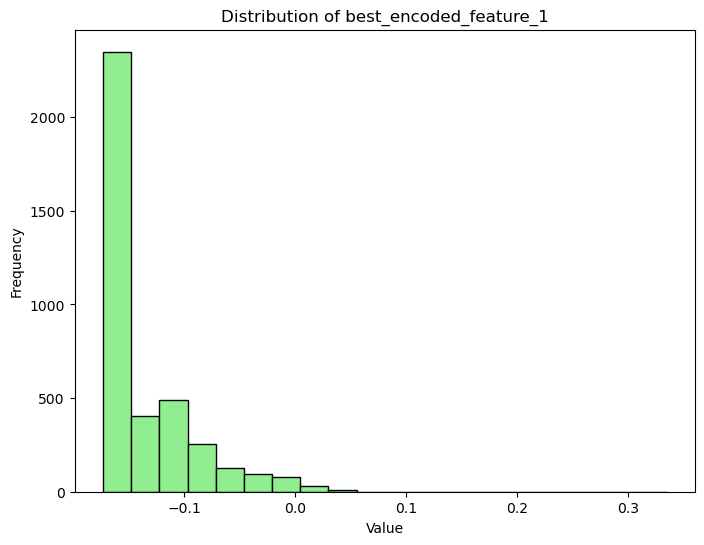


Correlation matrix including best_encoded_feature_1:
                        Country_enc  Mortality_Rate       GDP  At War_enc  \
Country_enc                1.000000       -0.127962  0.081108    0.016932   
Mortality_Rate            -0.127962        1.000000 -0.483591    0.043601   
GDP                        0.081108       -0.483591  1.000000   -0.076127   
At War_enc                 0.016932        0.043601 -0.076127    1.000000   
best_encoded_feature_1    -0.197876        0.968074 -0.481425    0.279460   

                        best_encoded_feature_1  
Country_enc                          -0.197876  
Mortality_Rate                        0.968074  
GDP                                  -0.481425  
At War_enc                            0.279460  
best_encoded_feature_1                1.000000  


In [16]:
# Explanation:
# "best_encoded_feature_1" is one of the latent (encoded) features obtained from the autoencoder 
# after optimizing its parameters by grid search. This feature represents a learned, compressed 
# representation of the original data. Examining its summary statistics, distribution, and correlations 
# with other key features can help in understanding what aspect of the data it captures.

# Print summary statistics for best_encoded_feature_1
print("Summary statistics for best_encoded_feature_1:")
print(df_best['best_encoded_feature_1'].describe())

# Plot histogram of best_encoded_feature_1
plt.figure(figsize=(8, 6))
plt.hist(df_best['best_encoded_feature_1'], bins=20, color='lightgreen', edgecolor='black')
plt.title("Distribution of best_encoded_feature_1")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Compute and display correlation of best_encoded_feature_1 with key features
key_features = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'best_encoded_feature_1']
corr_be1 = df_best[key_features].corr()
print("\nCorrelation matrix including best_encoded_feature_1:")
print(corr_be1)

Summary statistics for best_encoded_feature_2:
count    3844.000000
mean        0.140573
std         0.106305
min        -0.335974
25%         0.077835
50%         0.151389
75%         0.211326
max         0.451121
Name: best_encoded_feature_2, dtype: float64


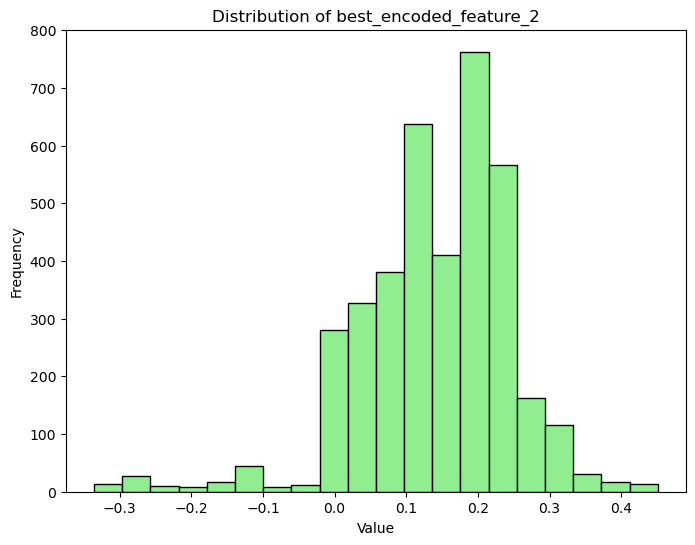


Correlation matrix including best_encoded_feature_2:
                        Country_enc  Mortality_Rate       GDP  At War_enc  \
Country_enc                1.000000       -0.127962  0.081108    0.016932   
Mortality_Rate            -0.127962        1.000000 -0.483591    0.043601   
GDP                        0.081108       -0.483591  1.000000   -0.076127   
At War_enc                 0.016932        0.043601 -0.076127    1.000000   
best_encoded_feature_2     0.616470        0.411398 -0.153347   -0.578618   

                        best_encoded_feature_2  
Country_enc                           0.616470  
Mortality_Rate                        0.411398  
GDP                                  -0.153347  
At War_enc                           -0.578618  
best_encoded_feature_2                1.000000  


In [18]:
# Explanation:
# "best_encoded_feature_2" is one of the latent (encoded) features obtained from the autoencoder 
# after optimizing its parameters by grid search. This feature represents a learned, compressed 
# representation of the original data. Examining its summary statistics, distribution, and correlations 
# with other key features can help in understanding what aspect of the data it captures.

# Print summary statistics for best_encoded_feature_2
print("Summary statistics for best_encoded_feature_2:")
print(df_best['best_encoded_feature_2'].describe())

# Plot histogram of best_encoded_feature_2
plt.figure(figsize=(8, 6))
plt.hist(df_best['best_encoded_feature_2'], bins=20, color='lightgreen', edgecolor='black')
plt.title("Distribution of best_encoded_feature_2")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

# Compute and display correlation of best_encoded_feature_2 with key features
key_features = ['Country_enc', 'Mortality_Rate', 'GDP', 'At War_enc', 'best_encoded_feature_2']
corr_be1 = df_best[key_features].corr()
print("\nCorrelation matrix including best_encoded_feature_2:")
print(corr_be1)

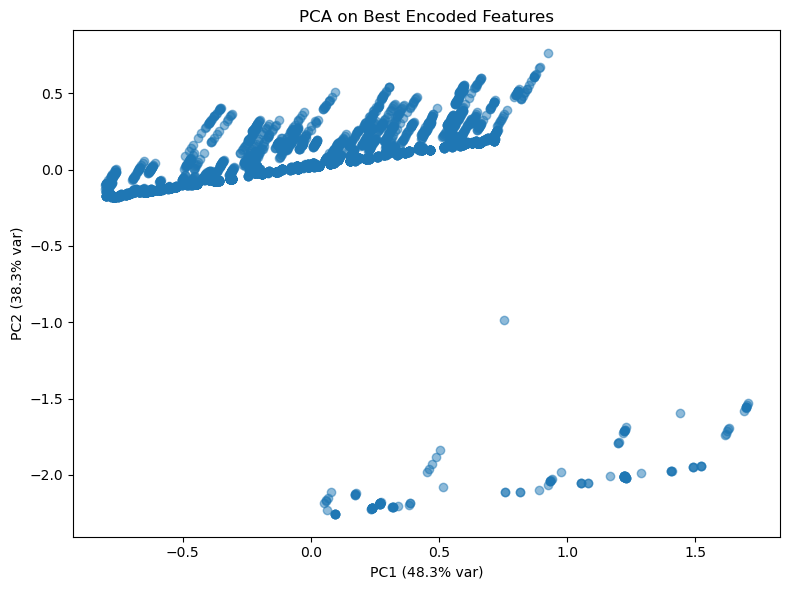

In [20]:
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

# Perform PCA on best encoded features (already predicted in encoded_features_best)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(encoded_features_best)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA on Best Encoded Features')
plt.tight_layout()
plt.show()

Look at the Encoded Freatures Mutual Information (MI): Mutual information (MI) between latent features and a target (or another feature) tells you how much information one variable provides about another — in this case, how informative your latent features are about the labels or original variables.

MI = 0: The latent feature gives no information about the target (they’re independent).

Higher MI (> 0): The latent feature is more informative — it captures some structure related to the target variable.

Maximum MI (bounded by entropy of the target): Implies perfect knowledge of the target from that latent feature.

In [22]:
from sklearn.feature_selection import mutual_info_classif

# Define encoded_data using the latent features generated previously (from encoded_df)
encoded_data = encoded_df.values

# Define y_data as the binary target (using the 'At War_enc' column from df)
y_data = df['At War_enc'].values

mi = mutual_info_classif(encoded_data, y_data)
print("Mutual Information:", mi)


Mutual Information: [0.15991952 0.09283477]


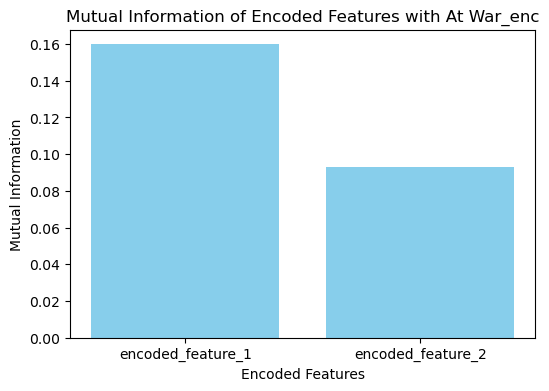

In [23]:
# Visualize mutual information as a bar chart
features = ['encoded_feature_1', 'encoded_feature_2']
plt.figure(figsize=(6, 4))
plt.bar(features, mi, color='skyblue')
plt.xlabel('Encoded Features')
plt.ylabel('Mutual Information')
plt.title('Mutual Information of Encoded Features with At War_enc')
plt.show()

A look at mutual information between latent and original input features.

High values show strong mutual information between a specific encoded feature and an original feature — suggesting that the autoencoder has learned to preserve that specific information.

Low values (≈ 0) indicate little to no information transfer for that pair.

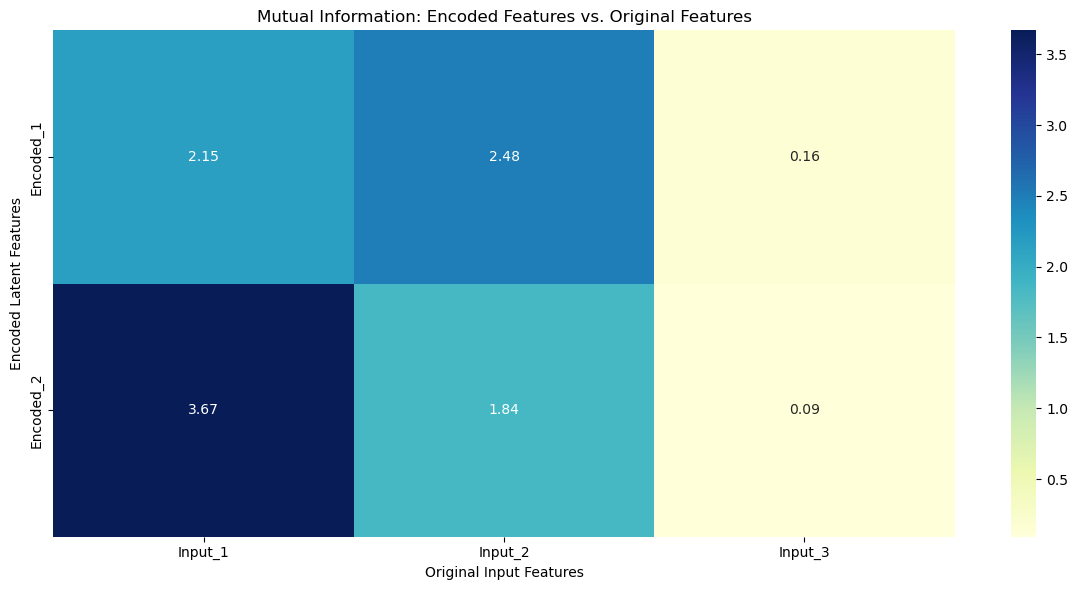

In [29]:
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
X_original = data  # Define X_original using the original numeric data (already defined in a previous cell)

# encoded_data: (n_samples, n_latent_features)
# X_original: (n_samples, n_input_features)

# Make sure X_original is numeric
if isinstance(X_original, pd.DataFrame):
    original_features = X_original.columns
else:
    original_features = [f"Input_{i+1}" for i in range(X_original.shape[1])]

encoded_feature_names = [f"Encoded_{i+1}" for i in range(encoded_data.shape[1])]

# Compute mutual information matrix
mi_matrix = np.zeros((encoded_data.shape[1], X_original.shape[1]))

for i in range(encoded_data.shape[1]):
    mi_matrix[i, :] = mutual_info_regression(X_original, encoded_data[:, i])

    # Create a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=encoded_feature_names, columns=original_features)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mi_df, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Mutual Information: Encoded Features vs. Original Features')
plt.xlabel('Original Input Features')
plt.ylabel('Encoded Latent Features')
plt.tight_layout()
plt.show()
